# AEGMM and VAEGMM outlier detection on KDD Cup '99 dataset

## Method

The *AEGMM* method follows the [Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection](https://openreview.net/forum?id=BJJLHbb0-) ICLR 2018 paper. The encoder compresses the data while the reconstructed instances generated by the decoder are used to create additional features based on the reconstruction error between the input and the reconstructions. These features are combined with encodings and fed into a Gaussian Mixture Model (GMM). Training of the *AEGMM* model is unsupervised on *normal* (inlier) data. The sample energy of the GMM can then be used to determine whether an instance is an outlier (*high sample energy*) or not (*low sample energy*). *VAEGMM* on the other hand uses a [variational autoencoder](https://arxiv.org/abs/1312.6114) instead of a plain autoencoder.

## Dataset

The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges;
- probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

- basic features of individual connections, e.g. duration of connection
- content features within a connection, e.g. number of failed log in attempts
- traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

This notebook requires the `seaborn` package for visualization which can be installed via `pip`:

In [ ]:
!pip install seaborn

In [2]:
import os
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, InputLayer

from alibi_detect.datasets import fetch_kdd
from alibi_detect.models.tensorflow import eucl_cosim_features
from alibi_detect.od import OutlierAEGMM, OutlierVAEGMM
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_tabular, plot_roc

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load dataset

We only keep a number of continuous (18 out of 41) features.

In [3]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


Assume that a model is trained on *normal* instances of the dataset (not outliers) and standardization is applied:

In [4]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float32'), normal_batch.target
print(X_train.shape, y_train.shape)
print('{}% outliers'.format(100 * y_train.mean()))

(400000, 18) (400000,)
0.0% outliers


In [5]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

Apply standardization:

In [6]:
X_train = (X_train - mean) / stdev

## Load or define AEGMM outlier detector

The pretrained outlier and adversarial detectors used in the example notebooks can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can train a detector from scratch:

In [7]:
load_outlier_detector = True

In [8]:
filepath = 'my_path'  # change to directory (absolute path) where model is downloaded
detector_type = 'outlier'
dataset = 'kddcup'
detector_name = 'OutlierAEGMM'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    # the model defined here is similar to the one defined in the original paper
    n_features = X_train.shape[1]
    latent_dim = 1
    n_gmm = 2  # nb of components in GMM

    encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(n_features,)),
        Dense(60, activation=tf.nn.tanh),
        Dense(30, activation=tf.nn.tanh),
        Dense(10, activation=tf.nn.tanh),
        Dense(latent_dim, activation=None)
    ])

    decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim,)),
        Dense(10, activation=tf.nn.tanh),
        Dense(30, activation=tf.nn.tanh),
        Dense(60, activation=tf.nn.tanh),
        Dense(n_features, activation=None)
    ])

    gmm_density_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim + 2,)),
        Dense(10, activation=tf.nn.tanh),
        Dense(n_gmm, activation=tf.nn.softmax)
    ])
    
    # initialize outlier detector
    od = OutlierAEGMM(threshold=None,  # threshold for outlier score
                      encoder_net=encoder_net,         # can also pass AEGMM model instead
                      decoder_net=decoder_net,         # of separate encoder, decoder
                      gmm_density_net=gmm_density_net, # and gmm density net
                      n_gmm=n_gmm,
                      recon_features=eucl_cosim_features)  # fn used to derive features
                                                           # from the reconstructed
                                                           # instances based on cosine 
                                                           # similarity and Eucl distance 
    
    # train
    od.fit(X_train,
           epochs=50,
           batch_size=1024,
           verbose=True)
    
    # save the trained outlier detector
    save_detector(od, filepath)

No threshold level set. Need to infer threshold using `infer_threshold`.


The warning tells us we still need to set the outlier threshold. This can be done with the `infer_threshold` method. We need to pass a batch of instances and specify what percentage of those we consider to be normal via `threshold_perc`. Let's assume we have some data which we know contains around 5% outliers. The percentage of outliers can be set with `perc_outlier` in the `create_outlier_batch` function.

In [9]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float32'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [10]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 12.8471097946167


Save outlier detector with updated threshold:

In [11]:
save_detector(od, filepath)

## Detect outliers

We now generate a batch of data with 10% outliers and detect the outliers in the batch. 

In [12]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float32'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


Predict outliers:

In [13]:
od_preds = od.predict(X_outlier, return_instance_score=True)

## Display results

F1 score and confusion matrix:

F1 score: 0.8889


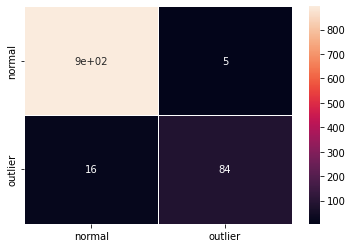

In [14]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {:.4f}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

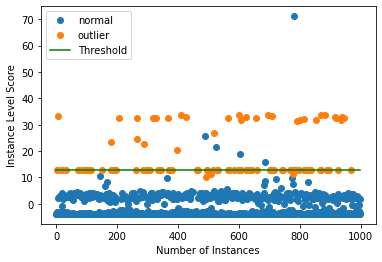

In [15]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold, ylim=(None, None))

We can also plot the ROC curve for the outlier scores of the detector:

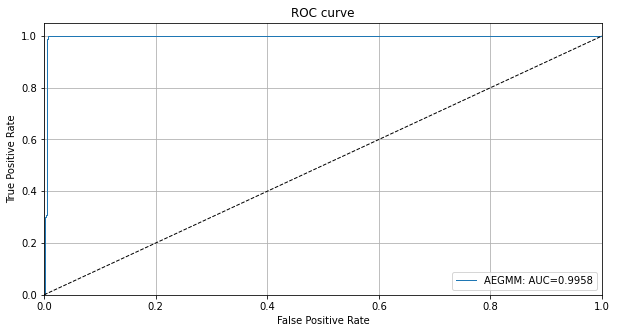

In [16]:
roc_data = {'AEGMM': {'scores': od_preds['data']['instance_score'], 'labels': y_outlier}}
plot_roc(roc_data)

## Investigate results

We can visualize the encodings of the instances in the latent space and the features derived from the instance reconstructions by the decoder. The encodings and features are then fed into the GMM density network.

In [17]:
enc = od.aegmm.encoder(X_outlier)  # encoding
X_recon = od.aegmm.decoder(enc)  # reconstructed instances
recon_features = od.aegmm.recon_features(X_outlier, X_recon)  # reconstructed features

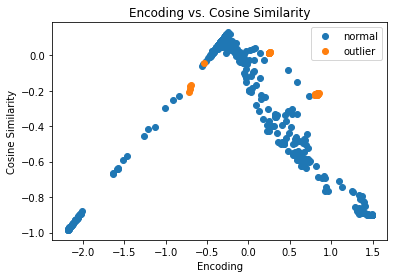

In [18]:
df = pd.DataFrame(dict(enc=enc[:, 0].numpy(), 
                       cos=recon_features[:, 0].numpy(), 
                       eucl=recon_features[:, 1].numpy(), 
                       label=y_outlier))

groups = df.groupby('label')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.enc, group.cos, marker='o', 
            linestyle='', ms=6, label=labels[name])
plt.title('Encoding vs. Cosine Similarity')
plt.xlabel('Encoding')
plt.ylabel('Cosine Similarity')
ax.legend()
plt.show()

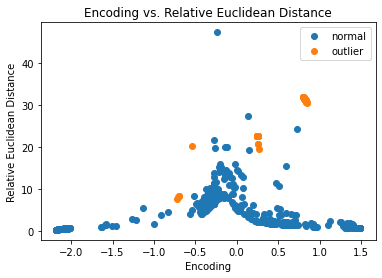

In [19]:
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.enc, group.eucl, marker='o', 
            linestyle='', ms=6, label=labels[name])
plt.title('Encoding vs. Relative Euclidean Distance')
plt.xlabel('Encoding')
plt.ylabel('Relative Euclidean Distance')
ax.legend()
plt.show()

A lot of the outliers are already separated well in the latent space.

## Use VAEGMM outlier detector

We can again instantiate the pretrained VAEGMM detector from the [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in ```fetch_detector``` function which saves the pre-trained models in a local directory ```filepath``` and loads the detector. Alternatively, you can train a detector from scratch:

In [20]:
load_outlier_detector = True

In [22]:
filepath = 'my_path'  # change to directory (absolute path) where model is downloaded
detector_type = 'outlier'
dataset = 'kddcup'
detector_name = 'OutlierVAEGMM'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    # the model defined here is similar to the one defined in
    # the OutlierVAE notebook
    n_features = X_train.shape[1]
    latent_dim = 2
    n_gmm = 2

    encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(n_features,)),
        Dense(20, activation=tf.nn.relu),
        Dense(15, activation=tf.nn.relu),
        Dense(7, activation=tf.nn.relu)
    ])

    decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim,)),
        Dense(7, activation=tf.nn.relu),
        Dense(15, activation=tf.nn.relu),
        Dense(20, activation=tf.nn.relu),
        Dense(n_features, activation=None)
    ])

    gmm_density_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim + 2,)),
        Dense(10, activation=tf.nn.relu),
        Dense(n_gmm, activation=tf.nn.softmax)
    ])
    
    
    # initialize outlier detector
    od = OutlierVAEGMM(threshold=None,
                       encoder_net=encoder_net,
                       decoder_net=decoder_net,
                       gmm_density_net=gmm_density_net,
                       n_gmm=n_gmm,
                       latent_dim=latent_dim,
                       samples=10,
                       recon_features=eucl_cosim_features)
    
    # train
    od.fit(X_train,
           epochs=50,
           batch_size=1024,
           cov_elbo=dict(sim=.0025),  # standard deviation assumption
           verbose=True)           # for elbo training
    
    # save the trained outlier detector
    save_detector(od, filepath)

No threshold level set. Need to infer threshold using `infer_threshold`.


Need to infer the threshold again:

In [23]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 8.69978871345519


Save outlier detector with updated threshold:

In [24]:
save_detector(od, filepath)

## Detect outliers and display results

Predict:

In [25]:
od_preds = od.predict(X_outlier, return_instance_score=True)

F1 score and confusion matrix:

F1 score: 0.9463


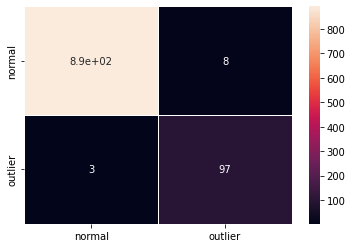

In [26]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {:.4f}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

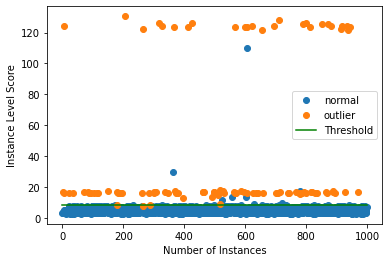

In [27]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold, ylim=(None, None))

You can zoom in by adjusting the min and max values in `ylim`. We can also compare the VAEGMM ROC curve with AEGMM:

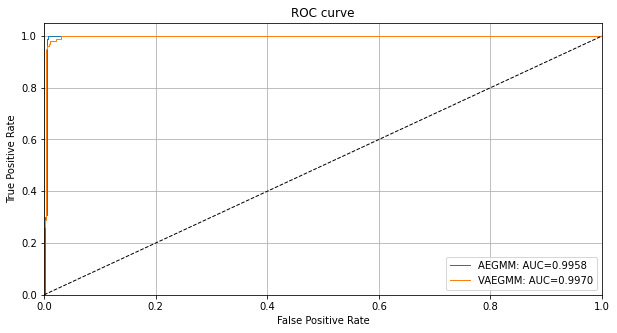

In [28]:
roc_data['VAEGMM'] = {'scores': od_preds['data']['instance_score'], 'labels': y_outlier}
plot_roc(roc_data)